In [1]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from datetime import datetime
from collections import Counter
import pickle

In [12]:
DATA_CSV = '../../data/sociology/911_calls_for_service.csv'#'../../data/sociology/location_geocoded.csv'

In [13]:
dframe = pd.read_csv(DATA_CSV)

In [4]:
'''
Constructs time series vector of binned counts from depCol for the indepValue in the indepCol
'''
def binTimes(dframe,indepCol,indepValue,depCol,timeRange):    
    minTime,maxTime = timeRange
    ts = np.zeros(maxTime - minTime + 1)
    
    cnt = Counter(dframe[dframe[indepCol] == indepValue][depCol])
    for key,value in cnt.items():
        ts[key-minTime] = value
    return ts

In [7]:
def addCol(colName = 'week'):
    def time2week(dtime, minYear=2015):
        dt = datetime.strptime(dtime,"%Y-%m-%d %H:%M:%S")
        return(dt.isocalendar()[1] + (dt.isocalendar()[0]-minYear)*52)
    
    if colName == 'week':
        func = time2week
    
    dframe[colName] = dframe.apply(lambda x: func(x.callDateTime),axis=1);
    timeRange = (min(dframe[colName]), max(dframe[colName]))
    
    return(dframe,timeRange)

In [14]:
def showTimeSeries(tsDict):
    plt.figure(figsize=(10,8))
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    for key,val in tsDict.items():
        plt.plot(val,label=key)
    plt.legend()

In [15]:
colName = 'week'
dframe,timeRange = addCol(colName)

In [18]:
tsDict = {}
regionCol = 'district'
for region in set(dframe[regionCol]):
    tsDict[region] = binTimes(dframe,regionCol,region,colName,timeRange)

In [19]:
import itertools
import warnings

In [22]:
def correlateTS(tsDict):
    n = len(tsDict.keys())
    corrMat = np.zeros((n,n))
    region2index = {i:j for i,j in zip(tsDict.keys(),range(n))}
    
    for a,b in itertools.combinations(tsDict.keys(), 2):
        tsa,tsb = tsDict[a],tsDict[b]
        
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                coeff = np.corrcoef(tsa,tsb)[0,1]
            except:
                coeff = 0
        corrMat[region2index[a]][region2index[b]] = float(coeff)
        if not a==b:
            corrMat[region2index[b]][region2index[a]] = float(coeff)
            
    return(corrMat,region2index)

In [23]:
corrMat,region2index = correlateTS(tsDict)

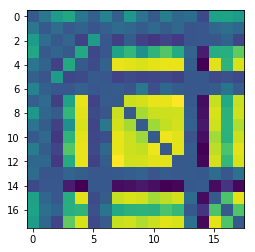

In [25]:
plt.imshow(corrMat)